# Setup and Load Data

***

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [2]:
import tensorflow as tf
import os

In [ ]:
#This is gonna list the number of GPUs available in the device
#Tenssorflow GPU Acceleration is only available upto 2.10 Version.
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)

In [ ]:
#To avoid OOM(Out Of Memory) error, set GPU to certain Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

***

# Remove dodgy images

***

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [4]:
data_directory_path = 'data'

In [5]:
os.listdir(os.path.join(data_directory_path,'happy'))

['05-12-21-happy-people.jpg',
 '106827976-1611251261868-twenty20_33fd1f3f-9221-4c64-bcb1-bfeec3022d9b.jpg',
 '110754-utyeqqosky-1547658396.jpeg',
 '170404-happy-workers-feature.jpg',
 '1920px-face-smile.svg_.png.jpg',
 '1HEoLBLidT2u4mhJ0oiDgig.png',
 '1_617fd1e2590c2.jpg',
 '20150413185238-secrets-happy-entrepreneurs-woman-gratitude-rainbow-.jpeg',
 '343515-worldhappinessreport1440.jpg',
 '35438_hd.jpg',
 '56f455011e0000b300705475.jpeg',
 '613k1XcpYCL.jpg',
 '68-684588_group-of-people-happy-people-transparent-background.png',
 '7-principles-of-successful-and-happy-people.png',
 '7VR73K6EP5ETVEOUFANWBUYJEQ.jpg',
 '835405.jpg',
 '988689_Wallpaper2.jpg',
 '9b65a25adca61c48bcb01370116723e3--happy-people-brings.jpg',
 'afro-girl-enjoying-the-sea-idyll-royalty-free-image-1661186370.jpg',
 'A_Sep20_14_1189155141.jpg',
 'cess-group-positive-friends-celebrate-victory-achievement-together_1016-9922.jpg',
 'compassion.jpg',
 'Dollarphotoclub_76084977-1.jpg',
 'Duggar-Family-Secrets-Are-Exposed-in

In [6]:
image_extension = ['jpeg','jpg','bmp','png']

In [ ]:
image = cv2.imread(os.path.join('data','happy','smile.woman_.jpg'))

In [ ]:
image.shape #heght, width, color(if color = 3:Colored, else:b&w)

In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
for image_class in os.listdir(data_directory_path):
    for image in os.listdir(os.path.join(data_directory_path, image_class)):
        image_path = os.path.join(data_directory_path, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extension:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {},{}'.format(image_path))

***

# Load Data

***

In [ ]:
tf.data.Dataset??

In [8]:
import numpy as np

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 163 files belonging to 2 classes.


Two classes are created one for happy people and one class for sad.

In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
#Get another batch from the iterator
batch = data_iterator.next()

In [12]:
len(batch) #Image Set and Label Set respectively will be batch, which can be accessed through indexing

2

In [13]:
#Images represented as numpy arrays
#Image dataset is divided into batches of 32 images by keras
batch[0].shape

(32, 256, 256, 3)

In [14]:
#The labels are represented as 1 and 0.
#Class 0 : Happy
#Class 1 : Sad
#For every iteration new batch 32 images is pushed throug the pipeline.
batch[1] 

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0])

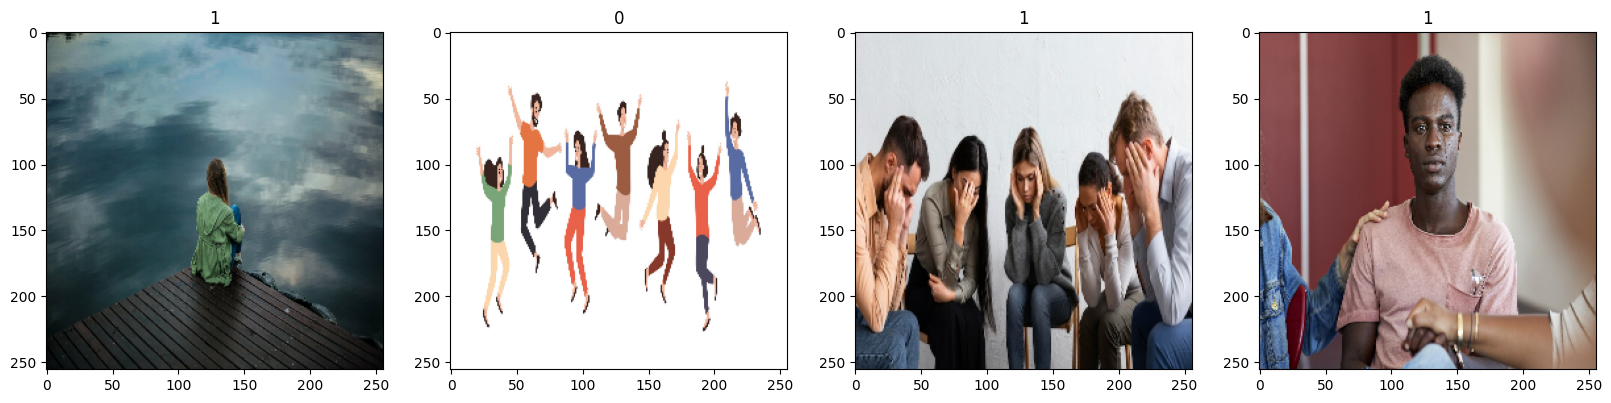

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int)) 
    #Converts the image data type to int for display purposes.
    #converts the pixel values of the image (img) to integers. 
    #This assumes that the original pixel values are already in a normalized range (e.g., 0-1) and multiplies them by 255 to scale them to the 0-255 range.
    ax[idx].title.set_text(batch[1][idx]) #Here scaled_batch[1] represents the label set.

***

# Preprocess Data

***

#### Scale Data = When we load the images, the values of each image is between 0 and 255. For optimizing we can scale the image's vale between 0 and 1.

In [ ]:
batch[0].min() 

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
scaled_batch = next(scaled_iterator)

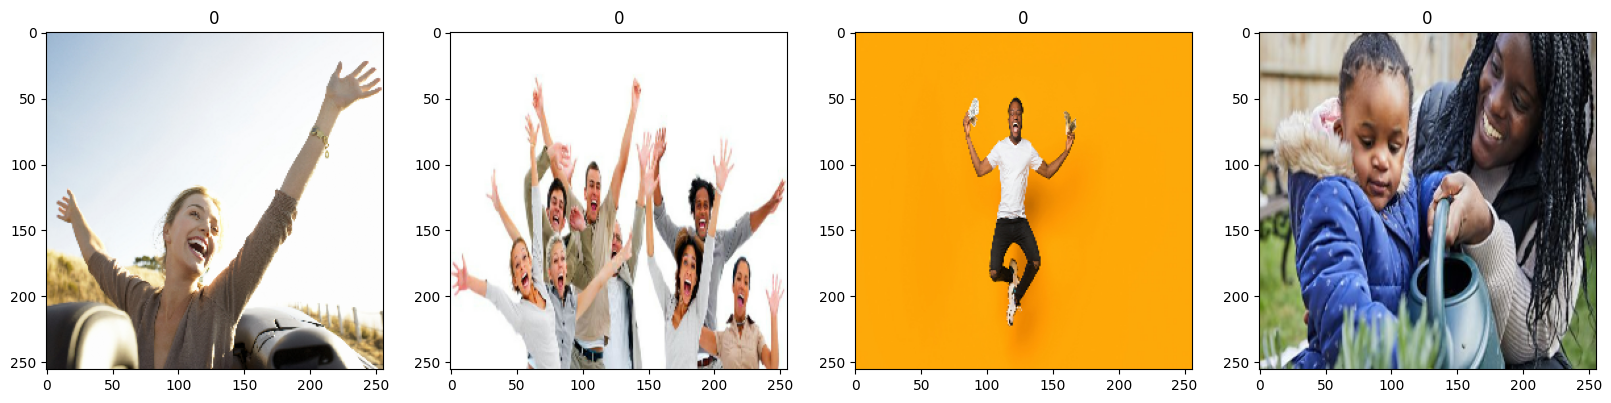

In [19]:
fig, plot = plt.subplots(ncols=4, figsize=(20,20))
for indx, img in enumerate(scaled_batch[0][:4]):
    plot[indx].imshow(img) #Here conversion to int is not possible as the scaling is done between 0 and 1.
    plot[indx].title.set_text(scaled_batch[1][indx]) #Here scaled_batch[1] represents the label set.

##### Split data for training, validation and testing

In [ ]:
# length of data(number of batches)
len(data)

In [20]:
train_size = int(len(data)*.7) #70% of batches
val_size = int(len(data)*.2) #20% of batches
test_size = int(len(data)*.1)+1 #10% of batches

In [21]:
train_size + val_size + test_size #total number of batches

6

In [22]:
#creating the data according to the above mentioned sizes.
train = data.take(train_size)
val = data.skip(train_size).take(val_size) #skip() method skips the alreay taken batches
test = data.skip(train_size + val_size).take(test_size)

##### Building Deep Learning models

In [25]:
from tensorflow.keras.models import Sequential # Keras Sequential Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten # Layers added to the model

In [28]:
model = Sequential()

In [30]:
# Layers are added one by one to the model in the sequential manner

model.add(Conv2D(16,(3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Single Output Layer 
# Here the sigmoid activation brings the value between 0 and 1, which is used for detection of sad and happy people.

In [31]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) #using optimazation module adam

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

##### Training the model

In [35]:
logdir = 'logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
# Training Component
# Epochs specify the number of runs over the training data set. If it is 1, its going to be 1 run over the training dataset.
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 2s/step - loss: 0.6571 - accuracy: 0.6250 - val_loss: 0.6144 - val_accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 11s 2s/step - loss: 0.6102 - accuracy: 0.6250 - val_loss: 0.5825 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 11s 2s/step - loss: 0.5649 - accuracy: 0.6641 - val_loss: 0.5881 - val_accuracy: 0.5312
Epoch 4/20
4/4 [==============================] - 11s 2s/step - loss: 0.5074 - accuracy: 0.7266 - val_loss: 0.5081 - val_accuracy: 0.7500
Epoch 5/20
4/4 [==============================] - 10s 2s/step - loss: 0.4977 - accuracy: 0.7734 - val_loss: 0.4679 - val_accuracy: 0.8438
Epoch 6/20
4/4 [==============================] - 10s 2s/step - loss: 0.5004 - accuracy: 0.7422 - val_loss: 0.3213 - val_accuracy: 0.7812
Epoch 7/20
4/4 [==============================] - 10s 2s/step - loss: 0.4339 - accuracy: 0.7969 - val_loss: 0.4256 - val_accuracy: 0.9062
Epoch 8/20
4/4 [==================

##### Plot Performance

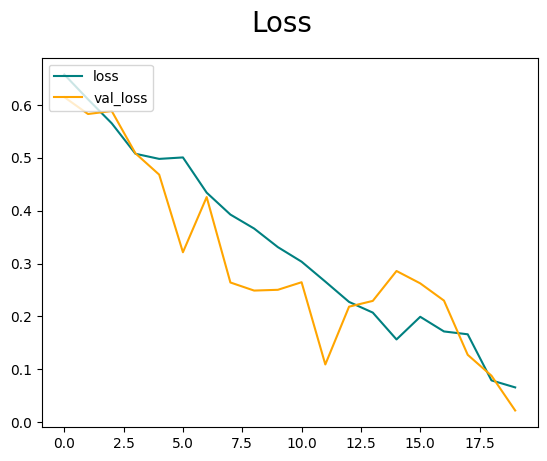

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

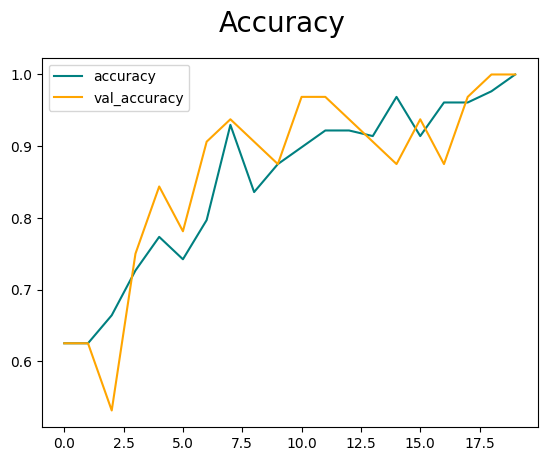

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Evaluate Performance

##### Evaluate

In [41]:
# Importing measures for this classification problem
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
# Creating instances for measures
pre = Precision()
rec = Recall()
accu = BinaryAccuracy()

In [49]:
for scaled_batch in test.as_numpy_iterator():
    X,y = scaled_batch # X= set of images
    yhat = model.predict(X) # yhat value will be either 0 or 1, its predicted, as of the images and that is done through sigmoid activation
    pre.update_state(y, yhat) # Here the comparison is done between y and yhat value, where y stores the orginal label of the image and yhat is the newly predcted one.
    rec.update_state(y, yhat)
    accu.update_state(y, yhat)

1/1 [==============================] - 0s 463ms/step


In [51]:
print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{accu.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


##### Test

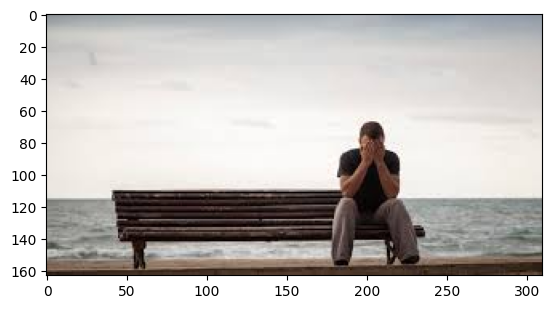

In [59]:
img = cv2.imread('sad_image_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

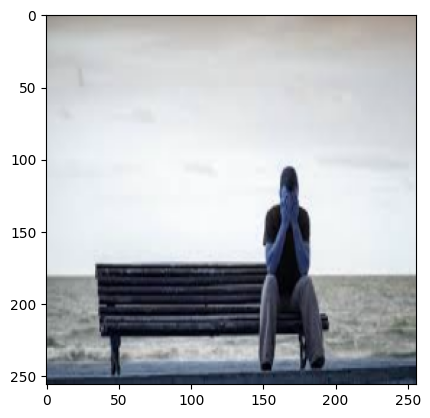

In [60]:
# For the neural network every image must be (256px Hight,256px Width, 3 Chanells(RGB))
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
#Passing the image thorugh the neural network
yhat = model.predict(np.expand_dims(resize/255, 0)) 

1/1 [==============================] - 0s 49ms/step


In [62]:
yhat

array([[0.9003156]], dtype=float32)

In [63]:
if yhat > 0.5 :
    print("The preidicted image is SAD")
else:
    print("The predicted image is HAPPY")

The preidicted image is SAD


# Saving the Model

In [65]:
from tensorflow.keras.models import load_model

In [66]:
model.save(os.path.join('Models','Happy_or_Sad_Image-Classification.h5'))

G:\ImageClassifcation\imageclassification\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
#Loading the model
new_model = load_model(os.path.join('Models','Happy_or_Sad_Image-Classification.h5'))

In [75]:
# Passing the resized image through the model
new_prediction = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 61ms/step


In [76]:
if new_prediction > 0.5:
    print("The predicted image is SAD")
else:
    print("The predicted image is HAPPY")

The predicted image is SAD
